# Feature Selection

In this notebook, I search for multicollinearity and the best features within my predictors

In [1]:
import pandas as pd
%config InlineBackend.figure_formats = ['svg']

In [2]:
df_train = pd.read_pickle("training_data_final_v3.pkl")
df_train.head()

,ID,orange_ping,orange_pos_x,orange_pos_y,orange_pos_z,orange_vel_x,orange_vel_y,orange_vel_z,orange_ang_vel_x,orange_ang_vel_y,...,orange_possesion,ball_dist_to_orange_goal,ball_dist_to_blue_goal,blue_dead,orange_dead,blue_dist_to_ball,blue_behind_ball,orange_dist_to_ball,orange_behind_ball,game_next_goal
0,116,14.0,255.929993,3839.489990,17.01,-65.700002,-412.400017,0.8,-0.2,1.3,...,False,5125.041181,5125.041181,False,False,3848.730157,True,3848.755458,True,1.0
1,117,14.0,255.929993,3839.489990,17.01,-65.700002,-412.400017,0.8,-0.2,1.3,...,False,5125.041181,5125.041181,False,False,3848.730157,True,3848.755458,True,1.0
2,118,14.0,253.520004,3827.120117,17.01,-487.900009,-2336.399994,0.0,-0.3,1.1,...,False,5125.041181,5125.041181,False,False,3835.681692,True,3836.255442,True,1.0
3,119,14.0,253.520004,3827.120117,17.01,-487.900009,-2336.399994,0.0,-0.3,1.1,...,False,5125.041181,5125.041181,False,False,3835.681692,True,3836.255442,True,1.0
4,120,14.0,248.229996,3799.129883,17.01,-665.999985,-4195.700073,-0.3,-0.8,-4.3,...,False,5125.041181,5125.041181,False,False,3806.720581,True,3807.983854,True,1.0


### Multicolinearity

By making a correlation squared matrix, we can search for multicollinearity by examing high R-Squared values between each pair of independent variables

In [3]:
df_rsq = df_train.corr(method='pearson').pow(2)

In [4]:
for col in df_rsq.columns:
    if len(df_rsq.loc[df_rsq[col] > 0.5, ].index) > 1:
        print(f"{col}: {df_rsq.loc[df_rsq[col] > 0.5, ].index}")
        print()

ID: Index(['ID', 'game_time', 'game_seconds_remaining', 'game_goal_number'], dtype='object')

orange_pos_x: Index(['orange_pos_x', 'blue_pos_x', 'ball_pos_x'], dtype='object')

orange_pos_y: Index(['orange_pos_y', 'blue_pos_y', 'ball_pos_y', 'ball_dist_to_orange_goal',
       'ball_dist_to_blue_goal'],
      dtype='object')

orange_jump_active: Index(['orange_jump_active', 'orange_dodge_active'], dtype='object')

orange_dodge_active: Index(['orange_jump_active', 'orange_dodge_active'], dtype='object')

blue_pos_x: Index(['orange_pos_x', 'blue_pos_x', 'ball_pos_x'], dtype='object')

blue_pos_y: Index(['orange_pos_y', 'blue_pos_y', 'ball_pos_y', 'ball_dist_to_orange_goal',
       'ball_dist_to_blue_goal'],
      dtype='object')

blue_jump_active: Index(['blue_jump_active', 'blue_dodge_active'], dtype='object')

blue_dodge_active: Index(['blue_jump_active', 'blue_dodge_active'], dtype='object')

ball_pos_x: Index(['orange_pos_x', 'blue_pos_x', 'ball_pos_x'], dtype='object')

ball_pos_y: I

From the above output, we see that there is multicollinearity present in some columns according to the high R-Squared values. The multicollinearity present also makes intuitive sense. Therefore, if we use these columns in our logistic model, we should add an interaction term. 

### Autocorrelation

In [5]:
df_train["ball_pos_y"].autocorr()

0.9976926631841778

Based on the extreme values of autocorrelation, we are in violation of the assumption that our observations are independent. Therefore, when doing the following testing, we should be extremely careful as our results may be somewhat misleading. 

### Non-Parametric Testing and R-Squared with Response

If the column is continuous, we can use many Mann-Whitney U Tests to determine a difference in distribution for independent variables given whether blue or orange scores the next goal. It makes sense to use a Mann-Whitney U Test because our data set is quite large, and also so we can save time by not needing to assess normality. 


If the column is categorical, Chi-Square test to determine a difference in proportion for independent variables given whether blue or orange scores the next goal. 


Note that these may be somewhat misleading due to the lack of independence from our samples, which is apparent via the high values of autocorrelation. 

C:\Users\mhugh\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


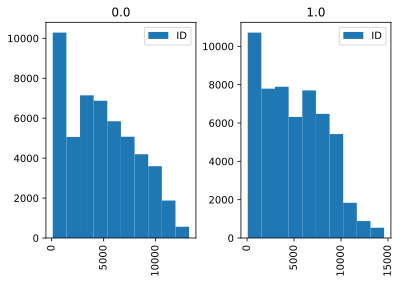

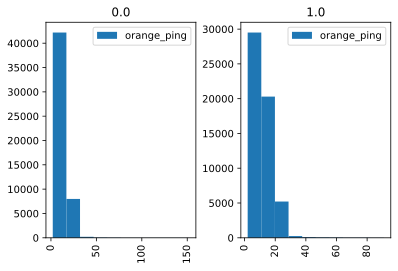

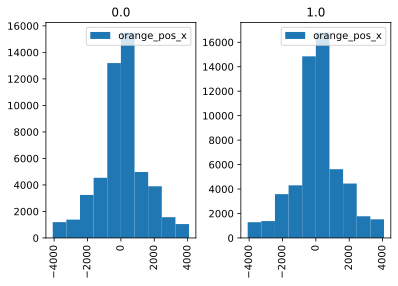

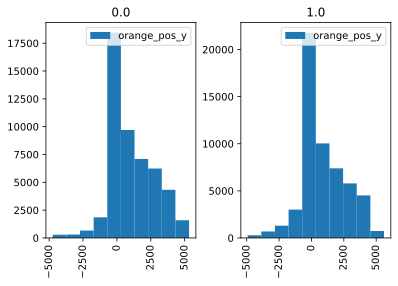

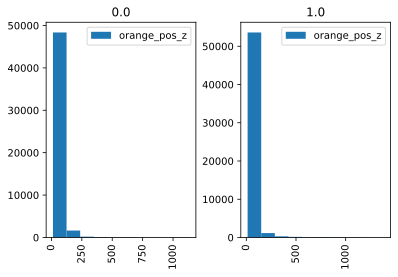

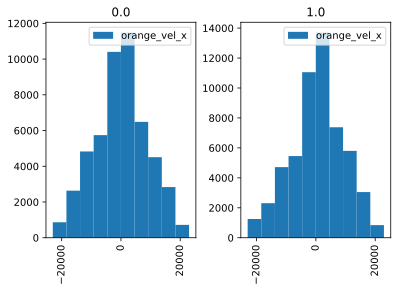

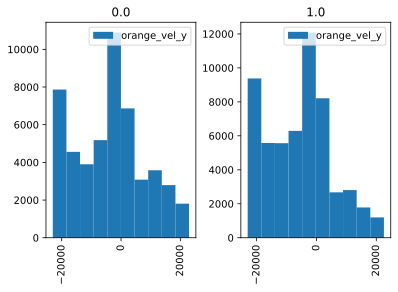

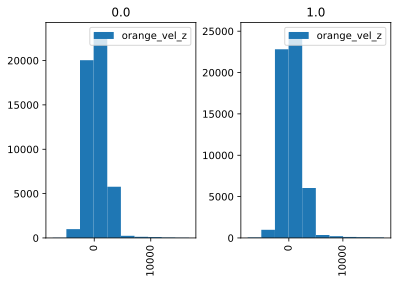

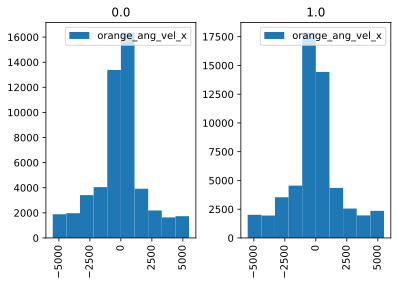

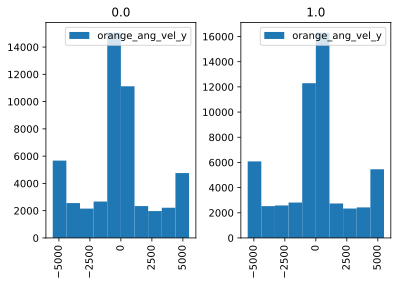

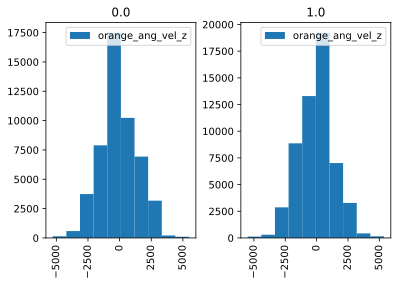

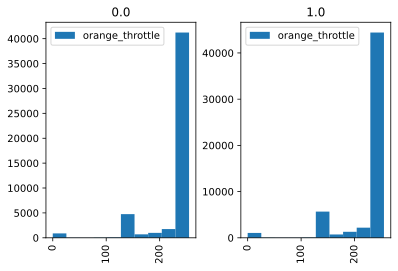

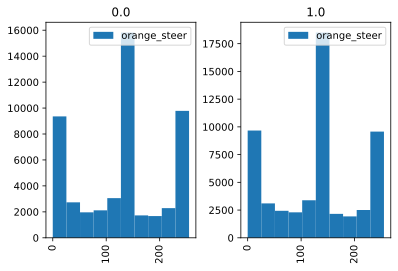

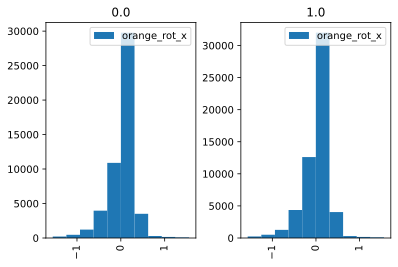

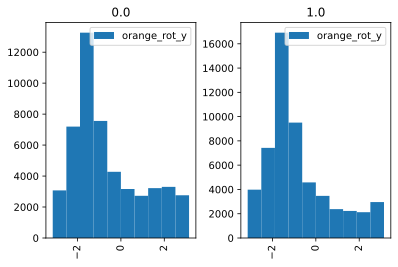

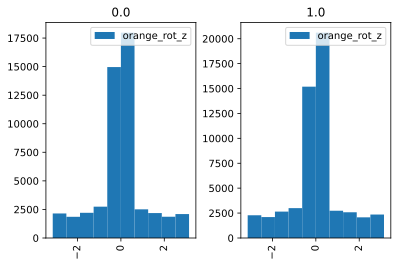

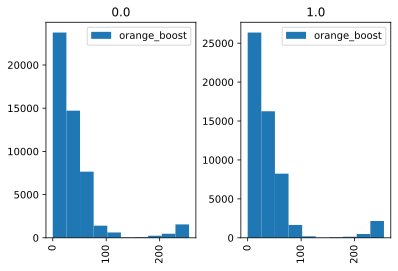

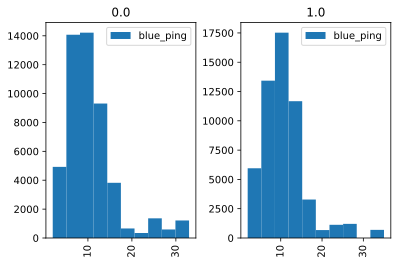

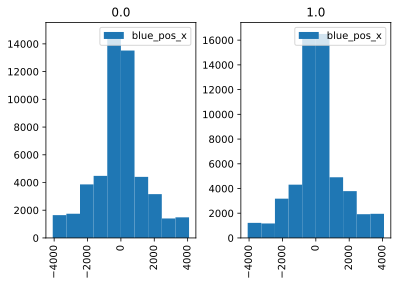

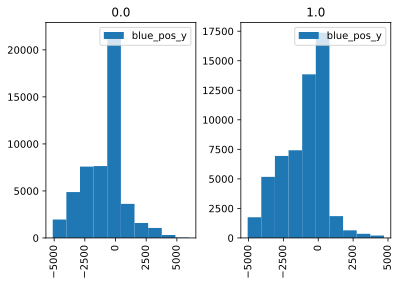

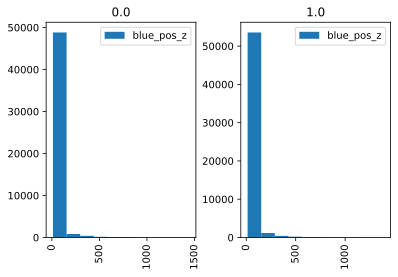

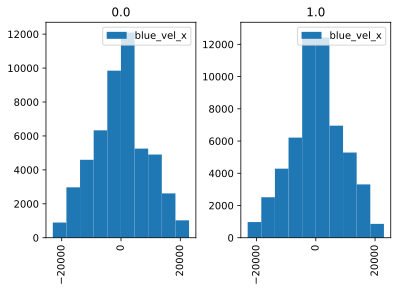

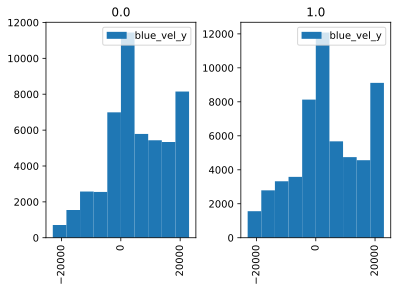

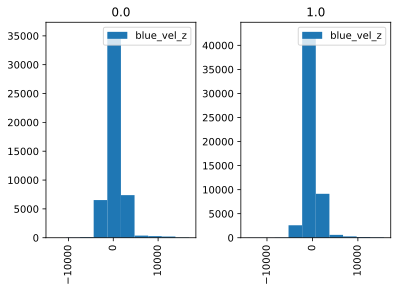

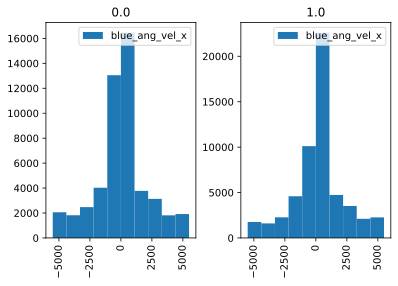

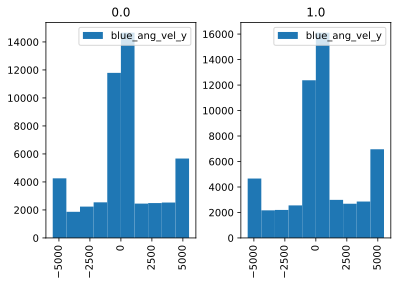

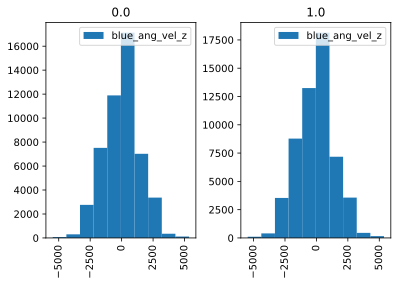

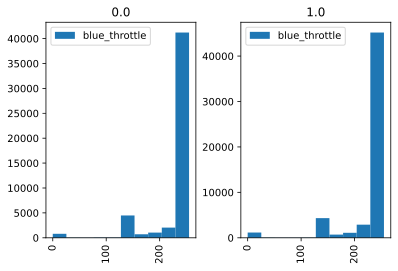

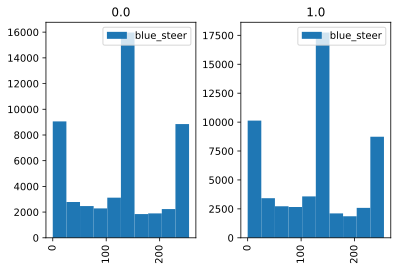

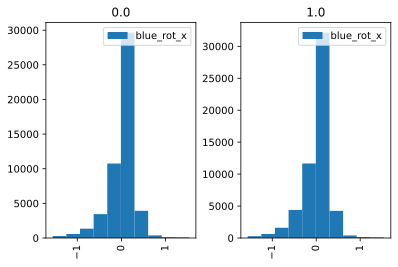

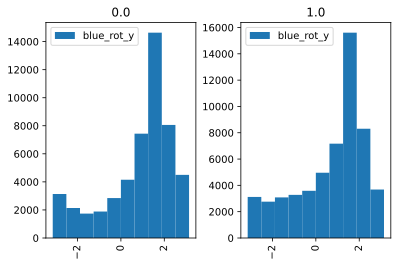

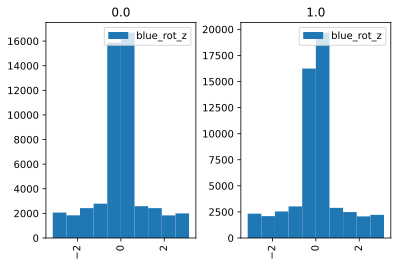

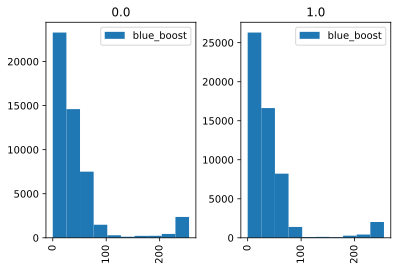

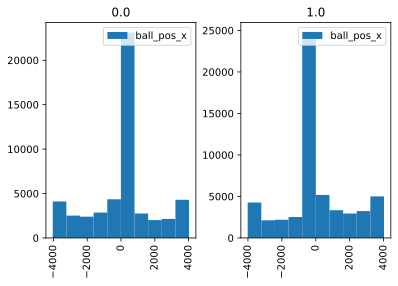

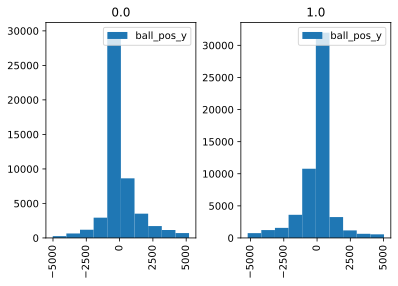

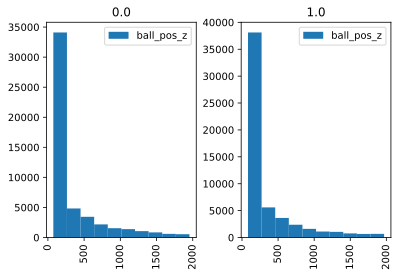

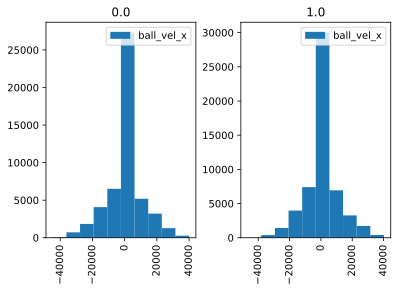

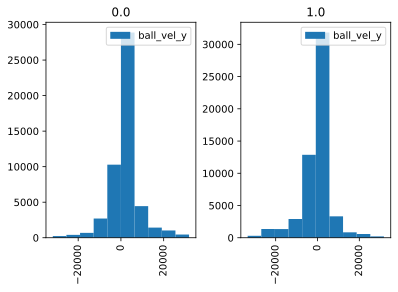

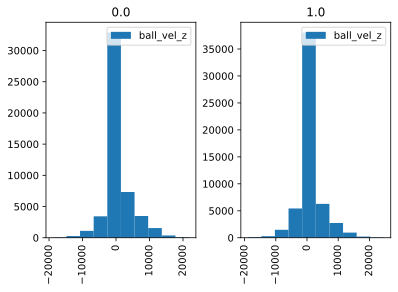

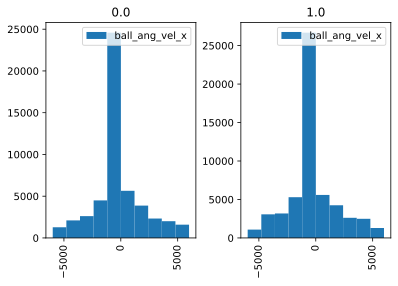

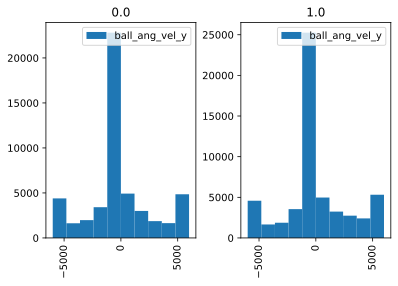

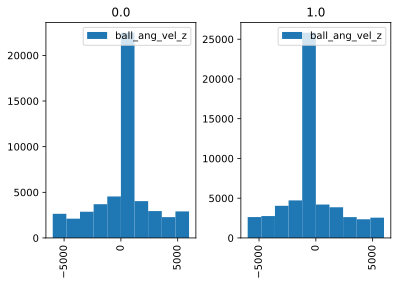

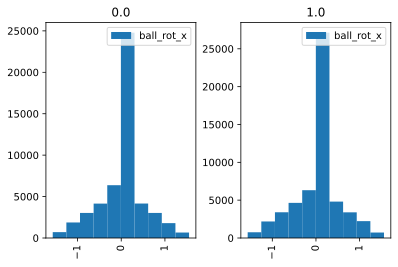

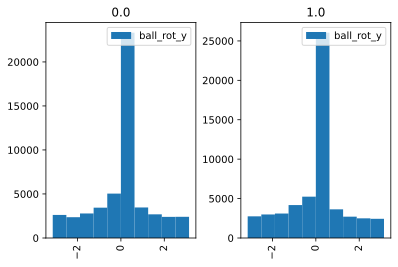

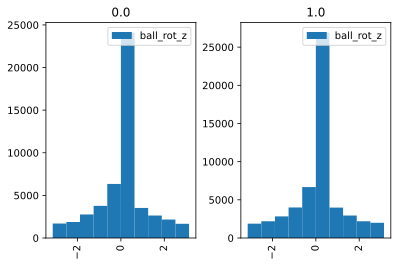

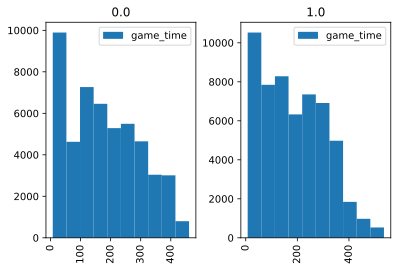

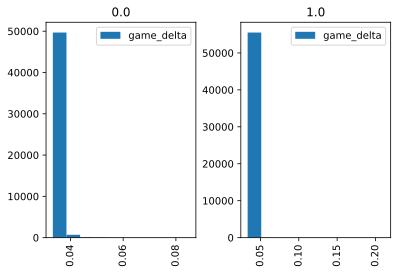

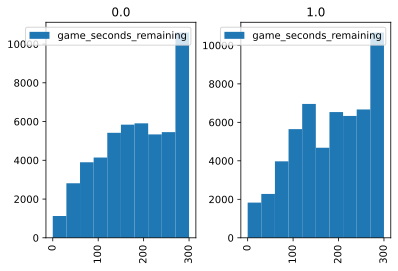

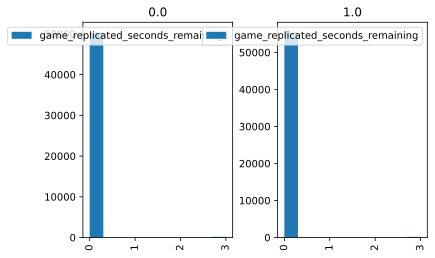

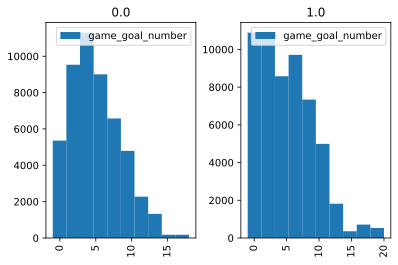

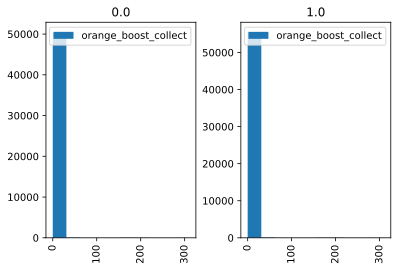

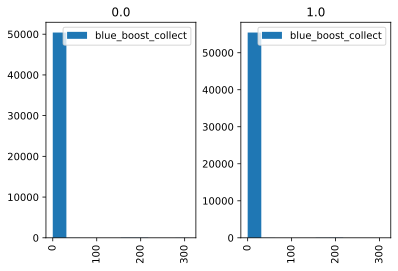

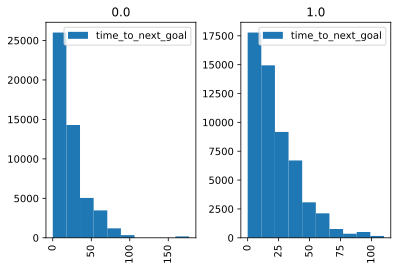

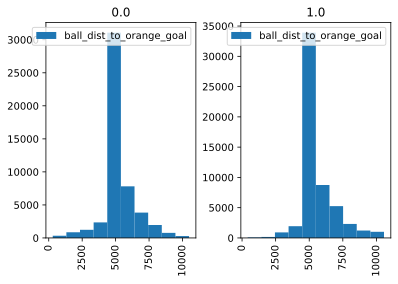

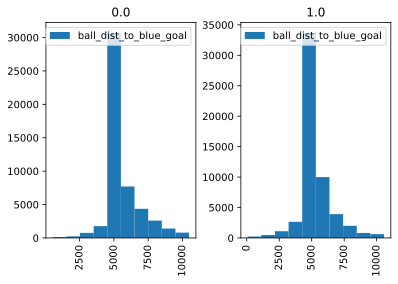

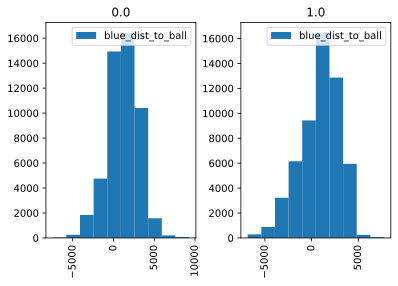

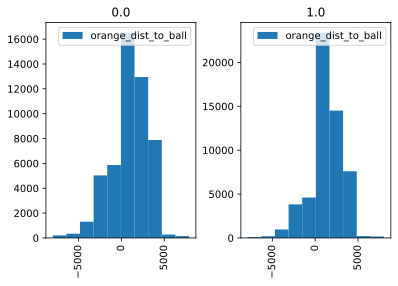

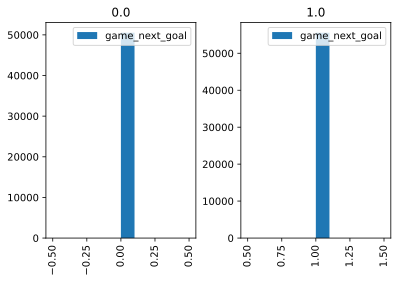

In [6]:
for col in df_train.columns:
    if df_train[col].dtype != "bool":
        df_train.dropna().hist(column = col, by = "game_next_goal", legend = True)

In [7]:
from scipy.stats import mannwhitneyu, chi2_contingency

In [8]:
p = [mannwhitneyu(df_train.loc[df_train["game_next_goal"] == 0, col].dropna(), 
                  df_train.loc[df_train["game_next_goal"] == 1, col].dropna(),
                 )[1].round(3) if df_train[col].dtype != "bool" 
     else chi2_contingency(pd.crosstab(df_train[col], df_train["game_next_goal"]))[1].round(3) 
     for col in df_train.columns]

We can use these P-Values as well as the R-Squared values of each individual predictor with the response variable to get an idea of what variables may be useful in the model. 

In [9]:
df_feature = pd.DataFrame({"P_Value": p, "R_Squared": df_rsq["game_next_goal"].round(3)})

with pd.option_context("display.max_rows", 1000):
    display(df_feature)

,P_Value,R_Squared
ID,0.000,0.001
orange_ping,0.000,0.001
orange_pos_x,0.000,0.000
orange_pos_y,0.000,0.006
orange_pos_z,0.000,0.000
orange_vel_x,0.000,0.000
orange_vel_y,0.000,0.017
orange_vel_z,0.600,0.000
orange_ang_vel_x,0.000,0.000
orange_ang_vel_y,0.000,0.000


### Feature Selection

Based on the output above and my intuition of over six years of playing Rocket League, I believe that the following variables should be included in the model to start with:

- **Blue Team**
    - blue_ping
    - blue_pos_x
    - blue_pos_y
    - blue_pos_z
    - blue_vel_x
    - blue_vel_y
    - blue_vel_z
    - blue_ang_vel_x
    - blue_ang_vel_y
    - blue_ang_vel_z
    - blue_rot_x
    - blue_rot_y
    - blue_rot_z
    - blue_jump_active
    - blue_dodge_active
    - blue_boost
    - blue_possesion
    - blue_dist_to_ball
    - blue_behind_ball
    - blue_dead

- **Orange Team**
    - orange_ping
    - orange_pos_x
    - orange_pos_y
    - orange_pos_z
    - orange_vel_x
    - orange_vel_y
    - orange_vel_z
    - orange_ang_vel_x
    - orange_ang_vel_y
    - orange_ang_vel_z
    - orange_rot_x
    - orange_rot_y
    - orange_rot_z
    - orange_jump_active
    - orange_dodge_active
    - orange_boost
    - orange_possesion
    - orange_dist_to_ball
    - orange_behind_ball
    - orange_dead

- **Ball**
    - ball_pos_x
    - ball_pos_y
    - ball_pos_z
    - ball_vel_x
    - ball_vel_y
    - ball_vel_z
    - ball_ang_vel_x
    - ball_ang_vel_y
    - ball_ang_vel_z
    - ball_dist_to_blue_goal
    - ball_dist_to_orange_goal

In [10]:
X = df_train[["blue_ping", 
              "blue_pos_x", 
              "blue_pos_y", 
              "blue_pos_z", 
              "blue_vel_x", 
              "blue_vel_y", 
              "blue_vel_z", 
              "blue_ang_vel_x", 
              "blue_ang_vel_y", 
              "blue_ang_vel_z", 
              "blue_rot_x", 
              "blue_rot_y", 
              "blue_rot_z", 
              "blue_jump_active", 
              "blue_dodge_active", 
              "blue_boost", 
              "blue_possesion", 
              "blue_dist_to_ball", 
              "blue_behind_ball", 
              "blue_dead", 
              "orange_ping", 
              "orange_pos_x", 
              "orange_pos_y", 
              "orange_pos_z", 
              "orange_vel_x", 
              "orange_vel_y", 
              "orange_vel_z", 
              "orange_ang_vel_x", 
              "orange_ang_vel_y", 
              "orange_ang_vel_z", 
              "orange_rot_x", 
              "orange_rot_y", 
              "orange_rot_z", 
              "orange_jump_active", 
              "orange_dodge_active", 
              "orange_boost", 
              "orange_possesion", 
              "orange_dist_to_ball", 
              "orange_behind_ball", 
              "orange_dead", 
              "ball_pos_x", 
              "ball_pos_y", 
              "ball_pos_z", 
              "ball_vel_x", 
              "ball_vel_y", 
              "ball_vel_z", 
              "ball_ang_vel_x", 
              "ball_ang_vel_y", 
              "ball_ang_vel_z", 
              "ball_dist_to_blue_goal", 
              "ball_dist_to_orange_goal"]].copy()
X.head()

,blue_ping,blue_pos_x,blue_pos_y,blue_pos_z,blue_vel_x,blue_vel_y,blue_vel_z,blue_ang_vel_x,blue_ang_vel_y,blue_ang_vel_z,...,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,ball_ang_vel_x,ball_ang_vel_y,ball_ang_vel_z,ball_dist_to_blue_goal,ball_dist_to_orange_goal
0,11.0,-256.000000,-3839.459961,17.01,0.000000,430.000000,0.8,0.6,0.0,0.0,...,0.0,92.739998,0.0,0.0,0.0,0.0,0.0,0.0,5125.041181,5125.041181
1,11.0,-256.000000,-3839.459961,17.01,0.000000,430.000000,0.8,0.6,0.0,0.0,...,0.0,92.739998,0.0,0.0,0.0,0.0,0.0,0.0,5125.041181,5125.041181
2,11.0,-256.000000,-3826.379883,17.01,0.000000,2472.299957,0.0,0.6,0.0,0.0,...,0.0,92.739998,0.0,0.0,0.0,0.0,0.0,0.0,5125.041181,5125.041181
3,11.0,-256.000000,-3826.379883,17.01,0.000000,2472.299957,0.0,0.6,0.0,0.0,...,0.0,92.739998,0.0,0.0,0.0,0.0,0.0,0.0,5125.041181,5125.041181
4,11.0,-254.630005,-3797.439941,17.01,457.999992,4215.899963,0.1,-0.1,-3.7,-1152.5,...,0.0,92.739998,0.0,0.0,0.0,0.0,0.0,0.0,5125.041181,5125.041181


In [11]:
X.describe().transpose()[["mean", "std", "min", "max"]].round(3)

,mean,std,min,max
blue_ping,10.745,5.476,2.000,35.000
blue_pos_x,83.715,2228.251,-4088.670,4089.670
blue_pos_y,-552.899,2928.037,-5986.960,5992.290
blue_pos_z,135.694,260.403,3.710,2037.190
blue_vel_x,32.083,10102.760,-22999.900,22999.900
blue_vel_y,1387.490,12251.745,-23000.000,22999.900
blue_vel_z,58.396,2822.037,-19205.100,22358.999
blue_ang_vel_x,-12.359,1848.725,-5500.000,5499.900
blue_ang_vel_y,68.838,2125.395,-5499.900,5499.900
blue_ang_vel_z,-7.327,1603.424,-5499.600,5499.700


In [12]:
cm = pd.crosstab(df_train['blue_possesion'], df_train['game_next_goal'],
                          rownames=['Blue Possesion'], colnames=['Goal Scoring Team'])
cm.columns = ["Blue", "Orange"]
cm

,Blue,Orange
Blue Possesion,,
False,103631,148492
True,123275,92481


### Exploratory Analysis Plots

In [13]:
import matplotlib.pyplot as plt
import seaborn as sn

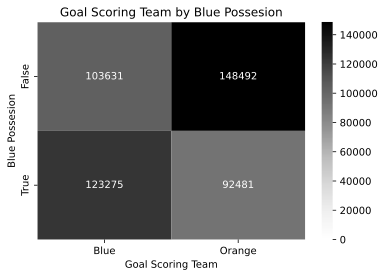

In [31]:
sn.heatmap(cm, annot=True, cmap = 'Greys', vmin = 0, fmt = 'g').set(title = "Goal Scoring Team by Blue Possession", 
                                                                    xlabel = "Goal Scoring Team")
plt.savefig("blue_possesion_next_goal.png")

In [15]:
df_sample = df_train.sample(1000)
df_sample.shape

(1000, 78)

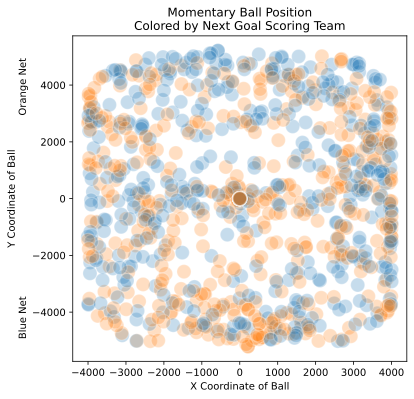

In [34]:
fig = plt.gcf()
fig.set_size_inches(6, 6)
p = sn.scatterplot(x = "ball_pos_x", y = "ball_pos_y", data = df_sample, 
                   hue = "game_next_goal", s = 200, alpha = 0.25, legend = False)
p.set(title = "Momentary Ball Position\nColored by Next Goal Scoring Team", xlabel = "X Coordinate of Ball", 
      ylabel = "Y Coordinate of Ball\nBlue Net                                                         Orange Net")
plt.savefig("ball_pos_next_goal.png", bbox_inches = 'tight')

In [17]:
df_train["game_next_goal"] = df_train["game_next_goal"].map({0: "Blue", 1: "Orange"})

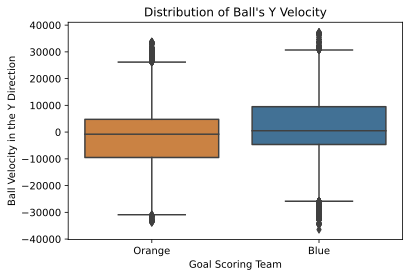

In [35]:
p = sn.boxplot(x = "game_next_goal", y = "ball_vel_y", data = df_train, palette = {"Blue": "#3473a3", "Orange": "#e1812c"})
p.set(title = "Distribution of Ball's Y Velocity", 
      xlabel = "Goal Scoring Team", ylabel = "Ball Velocity in the Y Direction")
plt.savefig("ball_vel_y_boxplot.png", bbox_inches = 'tight')

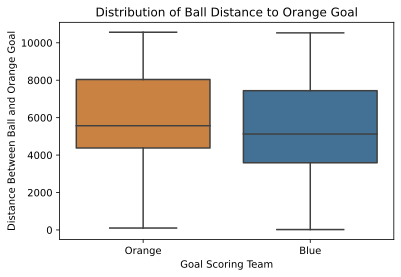

In [36]:
p = sn.boxplot(x = "game_next_goal", y = "ball_dist_to_orange_goal", 
               data = df_train, palette = {"Blue": "#3473a3", "Orange": "#e1812c"})
p.set(title = "Distribution of Ball Distance to Orange Goal", 
      xlabel = "Goal Scoring Team", ylabel = "Distance Between Ball and Orange Goal")
plt.savefig("ball_distance_boxplot.png", bbox_inches = 'tight')